In [184]:
import numpy as np
import pandas as pd
import orca
import os; os.chdir('/home/amelia/ual_model_workspace/spring-2019-models/')
import warnings; warnings.simplefilter('ignore')
from urbansim.utils import misc
import pandana as pdna
import geopandas as gp
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


In [58]:
from scripts import datasources, models, variables, utils

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [59]:
orca.run(['initialize_network_small', 'initialize_network_walk','impute_missing_skims']) 

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Running step 'impute_missing_skims'
Time to execute step 'impute_missing_skims': 109.49 s
Total time to execute iteration 1 with iteration value None: 109.49 s


In [3]:
chts_data = '/home/data/fall_2018/CHTS_csv_format/data'
!ls '/home/data/fall_2018/CHTS_csv_format/data'

ASSN_TravelDate.csv  Deliv_LD.csv     Deliv_VEH.csv    LookUp_PER.csv
Deliv_ACTIVITY.csv   Deliv_PER.csv    LookUp_Home.csv  LookUp_PLACE.csv
Deliv_HH.csv	     Deliv_PLACE.csv  LookUp_LD.csv


Read in cleaned data

In [89]:
school_trips_clean = pd.read_csv("school_trips_clean.csv")
# school_trips_clean["SMODE"]

In [21]:
# for c in school_trips_clean.columns:
#     print(c)

In [22]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH',
   'OWN','INCOM','HHSIZ']]

hh_df.head()

,SAMPN,HHVEH,OWN,INCOM,HHSIZ
0,1031985,2,1,3,2
1,1032036,1,1,7,5
2,1032053,2,2,2,6
3,1032425,2,1,7,2
4,1032558,0,2,1,1


#### 1. Merge hh dataframe with persons from cleaning notebook on SAMPN (household id) to get household-level demographic features

In [155]:
trips_hhvars = pd.merge(school_trips_clean, hh_df, on='SAMPN')
# sum(trips_hhvars["school_zone_id"].isna())

13

#### 2. Categorize races, incomes and ages and create dummy variables for mn logit


In [91]:
trips_hhvars['minority'] = np.where((trips_hhvars['HISP'].isin([1.0]) |
                                trips_hhvars['RACE1'].isin([2.0]) | trips_hhvars['RACE2'].isin([2.0]) | trips_hhvars['RACE3'].isin([2.0]) | trips_hhvars['RACE4'].isin([2.0]) |
                              trips_hhvars['RACE1'].isin([3.0]) | trips_hhvars['RACE2'].isin([3.0]) | trips_hhvars['RACE3'].isin([3.0]) | trips_hhvars['RACE4'].isin([3.0]) |
                              trips_hhvars['RACE1'].isin([4.0]) | trips_hhvars['RACE2'].isin([4.0]) | trips_hhvars['RACE3'].isin([4.0]) | trips_hhvars['RACE4'].isin([4.0]) |
                              trips_hhvars['RACE1'].isin([5.0]) | trips_hhvars['RACE2'].isin([5.0]) | trips_hhvars['RACE3'].isin([5.0]) | trips_hhvars['RACE4'].isin([5.0]) |
                              trips_hhvars['RACE1'].isin([97.0]) | trips_hhvars['RACE2'].isin([97.0]) | trips_hhvars['RACE3'].isin([97.0]) | trips_hhvars['RACE4'].isin([97.0])),1,0)

trips_hhvars['HISP'] = np.where(trips_hhvars['HISP'].isin([1.0]),1,0)
trips_hhvars['black'] = np.where((trips_hhvars['RACE1'].isin([2.0]) | trips_hhvars['RACE2'].isin([2.0]) | trips_hhvars['RACE3'].isin([2.0]) | trips_hhvars['RACE4'].isin([2.0])),1,0)
trips_hhvars['native'] = np.where((trips_hhvars['RACE1'].isin([3.0]) | trips_hhvars['RACE2'].isin([3.0]) | trips_hhvars['RACE3'].isin([3.0]) | trips_hhvars['RACE4'].isin([3.0])),1,0)
trips_hhvars['asian'] = np.where((trips_hhvars['RACE1'].isin([4.0]) | trips_hhvars['RACE2'].isin([4.0]) | trips_hhvars['RACE3'].isin([4.0]) | trips_hhvars['RACE4'].isin([4.0])),1,0)
trips_hhvars['PI'] = np.where((trips_hhvars['RACE1'].isin([5.0]) | trips_hhvars['RACE2'].isin([5.0]) | trips_hhvars['RACE3'].isin([5.0]) | trips_hhvars['RACE4'].isin([5.0])),1,0)


In [92]:
trips_hhvars['hh_inc_less10k'] = np.where(trips_hhvars['INCOM'].isin([1.0]),1,0)
trips_hhvars['hh_inc_10kless25k'] = np.where(trips_hhvars['INCOM'].isin([2.0]),1,0)
trips_hhvars['hh_inc_25kless35k'] = np.where(trips_hhvars['INCOM'].isin([3.0]),1,0)
trips_hhvars['hh_inc_35kless50k'] = np.where(trips_hhvars['INCOM'].isin([4.0]),1,0)
trips_hhvars['hh_inc_50kless75k'] = np.where(trips_hhvars['INCOM'].isin([5.0]),1,0)
#trips_hhvars trips1['hh_inc_75kless100k'] = np.where(trips1['INCOM'].isin([6.0]),1,0)
trips_hhvars['hh_inc_100kless150k'] = np.where(trips_hhvars['INCOM'].isin([7.0]),1,0)
trips_hhvars['hh_inc_150kless200k'] = np.where(trips_hhvars['INCOM'].isin([8.0]),1,0)
trips_hhvars['hh_inc_200kless250k'] = np.where(trips_hhvars['INCOM'].isin([9.0]),1,0)
# trips1['250kplus'] = np.where(trips1['INCOM'].isin([10.0]),1,0)

trips_hhvars['hh_inc_less50k'] = np.where(trips_hhvars['INCOM'].isin([1.0,2.0,3.0,4.0]),1,0)
# trips1['less75k'] = np.where(trips1['INCOM'].isin([1.0,2.0,3.0,4.0,5.0]),1,0)
# trips1['150kless250k'] = np.where(trips1['INCOM'].isin([8.0,9.0]),1,0)
# trips1['150kplus'] = np.where(trips1['INCOM'].isin([8.0,9.0,10.0]),1,0)

trips_hhvars['hh_inc_less75k'] = np.where(trips_hhvars['INCOM'].isin([1.0,2.0,3.0,4.0,5.0]),1,0)
trips_hhvars['hh_inc_75kless100k'] = np.where(trips_hhvars['INCOM'].isin([6.0]),1,0)
trips_hhvars['hh_inc_150kplus'] = np.where(trips_hhvars['INCOM'].isin([8.0,9.0,10.0]),1,0)
trips_hhvars['hh_inc_150kless250k'] = np.where(trips_hhvars['INCOM'].isin([8.0,9.0]),1,0)
trips_hhvars['hh_inc_250kplus'] = np.where(trips_hhvars['INCOM'].isin([10.0]),1,0)

In [69]:
# trips_hhvars['lessGED'] = np.where(trips_hhvars['EDUCA'].isin([1.0]),1,0)
# trips_hhvars['GED'] = np.where(trips_hhvars['EDUCA'].isin([2.0]),1,0)
# trips_hhvars['somebach'] = np.where(trips_hhvars['EDUCA'].isin([3.0]),1,0)
# trips_hhvars['Assoc'] = np.where(trips_hhvars['EDUCA'].isin([4.0]),1,0)
# trips_hhvars['Bach'] = np.where(trips_hhvars['EDUCA'].isin([5.0]),1,0)

# trips_hhvars['lessGED_GED'] = np.where(trips_hhvars['EDUCA'].isin([1.0,2.0]),1,0)

# trips_hhvars['lessbach'] = (trips_hhvars['EDUCA'] < 5).astype(int)


In [93]:
trips_hhvars['age_2less5'] = (trips_hhvars["AGE"] >= 2.0) & (trips_hhvars["AGE"] < 5.0)#pre k/k
trips_hhvars['age_5less10'] = (trips_hhvars["AGE"] >= 5.0) & (trips_hhvars["AGE"] < 10.0)  #1st-5th (elem)
trips_hhvars['age_10less14'] = (trips_hhvars["AGE"] >= 10.0) & (trips_hhvars["AGE"] < 14.0) #6th-8th (middle)
trips_hhvars['age_14less19'] = (trips_hhvars["AGE"] >= 14.0) & (trips_hhvars["AGE"] < 19.0)#9th-12th (high)



In [94]:
trips_hhvars['female'] = trips_hhvars['GEND'] - 1

trips_hhvars['tenure_2'] = trips_hhvars['OWN'] - 1

trips_hhvars['noveh'] = np.where(trips_hhvars.HHVEH.isin([0.0]),1,0)
trips_hhvars['1veh'] = np.where(trips_hhvars.HHVEH.isin([1.0]),1,0)
trips_hhvars['2veh'] = np.where(trips_hhvars.HHVEH.isin([2.0]),1,0)
trips_hhvars['3plusveh'] = np.where(trips_hhvars.HHVEH.between(3,8,inclusive = True),1,0)

trips_hhvars['hh_size_1per'] = np.where(trips_hhvars.HHSIZ.isin([1.0]),1,0)
trips_hhvars['hh_size_2per'] = np.where(trips_hhvars.HHSIZ.isin([2.0]),1,0)
trips_hhvars['hh_size_3per'] = np.where(trips_hhvars.HHSIZ.isin([3.0]),1,0)
trips_hhvars['hh_size_4plusper'] = np.where(trips_hhvars.HHSIZ.between(4,8,inclusive = True),1,0)

#### Turn Modes into categorical variables

In [97]:
# def categorize_modes(code):
#     if (code == 1):
#         return "walk"
#     elif (code == 2):
#         return "bike"
#     elif (code ==4):
#         return = "other_non_motor"
#     elif (code == 5):
#         return = "auto_driver"
#     elif (code == 6):
#         return = "auto_passenger"
#     elif (code == 7):
#         return = "other_non_motor"
#     elif (code == 10):
#         return = "other_non_motor"


# trips_hhvars["SMODE"]

#### 3. Add BEAM skims for generalized cost

In [98]:
beam_skims = orca.get_table('beam_skims').to_frame()
reset_beam_skims = beam_skims.reset_index()


In [135]:
reset_beam_skims.head()
reset_beam_skims.isna().sum(axis=0)

from_zone_id                  0
to_zone_id                    0
dist                          0
gen_cost_BIKE                 0
gen_cost_CAR                  0
gen_cost_DRIVE_TRANSIT        0
gen_cost_RIDE_HAIL            0
gen_cost_RIDE_HAIL_POOLED     0
gen_cost_RIDE_HAIL_TRANSIT    0
gen_cost_WALK                 0
gen_cost_WALK_TRANSIT         0
gen_tt_BIKE                   0
gen_tt_CAR                    0
gen_tt_DRIVE_TRANSIT          0
gen_tt_RIDE_HAIL              0
gen_tt_RIDE_HAIL_POOLED       0
gen_tt_RIDE_HAIL_TRANSIT      0
gen_tt_WALK                   0
gen_tt_WALK_TRANSIT           0
dtype: int64

In [158]:
trips_hhvars_1 = trips_hhvars.drop(["RACE2", "RACE3", "RACE4", "O_RACE"], axis=1).dropna(subset=["school_zone_id"])
reset_beam_skims1 = reset_beam_skims.dropna()
trips_hhvars_1.isna().sum(axis=0)

Unnamed: 0                        0
SAMPN                             0
PERNO                             0
RELAT                             0
GEND                              0
AGE                               0
HISP                              0
RACE1                             0
NTVTY                             0
STUDE                             0
SCITY_persons                     0
SSTAT                             0
SZIP_persons                      0
SMODE                             0
EDUCA                             0
SNAME_lookup                      0
SCITY_lookup                      0
SZIP_lookup                       0
SCTFIP_lookup                     0
STRACT_lookup                     0
SBLOCK                            0
SPrimaryCity_lookup               0
SSTFIP_lookup                     0
HCITY                             0
HZIP                              0
HXCORD                            0
HYCORD                            0
HBLOCK                      

In [159]:
trips_skims = pd.merge(reset_beam_skims1, trips_hhvars_1,  how='right', right_on=['zone_id_home','school_zone_id'], left_on = ['from_zone_id','to_zone_id'])
trips_skims.head()

,from_zone_id,to_zone_id,dist,gen_cost_BIKE,gen_cost_CAR,gen_cost_DRIVE_TRANSIT,gen_cost_RIDE_HAIL,gen_cost_RIDE_HAIL_POOLED,gen_cost_RIDE_HAIL_TRANSIT,gen_cost_WALK,...,nodeID,school_parcel_id,school_zone_id,activity_start,activity_end,calc_trip_dwell,HHVEH,OWN,INCOM,HHSIZ
0,12,99,8529.5020,10.972519,5.040548,6.434768,25.446497,13.960627,13.689966,1259.232441,...,258967888.0,1019806.0,99.0,8.083333,17.25,9.166667,1,1,10,3
1,17,20,2414.0100,3.105430,1.426570,1.821161,13.701745,3.951121,3.874519,7.865417,...,65286126.0,982109.0,20.0,7.166667,16.25,9.083333,1,1,7,4
2,17,20,2414.0100,3.105430,1.426570,1.821161,13.701745,3.951121,3.874519,7.865417,...,65286126.0,982109.0,20.0,7.166667,16.25,9.083333,1,1,7,4
3,29,808,43709.6744,56.228982,25.830430,32.975153,130.401294,71.541627,70.154619,6452.972284,...,263087528.0,283218.0,808.0,7.500000,14.50,7.000000,2,1,7,2
4,36,40,1416.2192,1.821852,3.609543,1.068414,4.225079,2.317991,2.273051,209.080103,...,260336116.0,896351.0,40.0,9.283333,9.55,0.266667,1,1,6,5


In [83]:
for c in trips_skims.columns:
    print(c)

from_zone_id
to_zone_id
dist
gen_cost_BIKE
gen_cost_CAR
gen_cost_DRIVE_TRANSIT
gen_cost_RIDE_HAIL
gen_cost_RIDE_HAIL_POOLED
gen_cost_RIDE_HAIL_TRANSIT
gen_cost_WALK
gen_cost_WALK_TRANSIT
gen_tt_BIKE
gen_tt_CAR
gen_tt_DRIVE_TRANSIT
gen_tt_RIDE_HAIL
gen_tt_RIDE_HAIL_POOLED
gen_tt_RIDE_HAIL_TRANSIT
gen_tt_WALK
gen_tt_WALK_TRANSIT
Unnamed: 0
SAMPN
PERNO
RELAT
GEND
AGE
HISP
RACE1
RACE2
RACE3
RACE4
O_RACE
NTVTY
STUDE
SCITY_persons
SSTAT
SZIP_persons
EDUCA
SNAME_lookup
SCITY_lookup
SZIP_lookup
SCTFIP_lookup
STRACT_lookup
SBLOCK
SPrimaryCity_lookup
SSTFIP_lookup
HCITY
HZIP
HXCORD
HYCORD
HBLOCK
HTRACT
HCTFIP
HPrimaryCity
parcel_id_home
parcel_id_work
zone_id_home
zone_id_work
school_id
HHPER
HHPERPLA
APURP1
APURP2
APURP3
PNAME
trip_type
ARR_HR
ARR_MIN
DEP_HR
DEP_MIN
TRIPDUR
CDSCode
School
District
County
Street
City
Zip
State
Latitude
Longitude
type
grade_0
grade_1
grade_2
grade_3
grade_4
grade_5
grade_6
grade_7
grade_8
grade_9
grade_10
grade_11
grade_12
Kindergarten Enrollment
Grade 1 Enrollme

#### 5. Use random forest as a first pass at feature importances

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=50, random_state=0)

In [190]:
for c in trips_skims.columns:
    print(c)

from_zone_id
to_zone_id
dist
gen_cost_BIKE
gen_cost_CAR
gen_cost_DRIVE_TRANSIT
gen_cost_RIDE_HAIL
gen_cost_RIDE_HAIL_POOLED
gen_cost_RIDE_HAIL_TRANSIT
gen_cost_WALK
gen_cost_WALK_TRANSIT
gen_tt_BIKE
gen_tt_CAR
gen_tt_DRIVE_TRANSIT
gen_tt_RIDE_HAIL
gen_tt_RIDE_HAIL_POOLED
gen_tt_RIDE_HAIL_TRANSIT
gen_tt_WALK
gen_tt_WALK_TRANSIT
Unnamed: 0
SAMPN
PERNO
RELAT
GEND
AGE
HISP
RACE1
NTVTY
STUDE
SCITY_persons
SSTAT
SZIP_persons
SMODE
EDUCA
SNAME_lookup
SCITY_lookup
SZIP_lookup
SCTFIP_lookup
STRACT_lookup
SBLOCK
SPrimaryCity_lookup
SSTFIP_lookup
HCITY
HZIP
HXCORD
HYCORD
HBLOCK
HTRACT
HCTFIP
HPrimaryCity
parcel_id_home
parcel_id_work
zone_id_home
zone_id_work
school_id
HHPER
HHPERPLA
APURP1
APURP2
APURP3
PNAME
trip_type
ARR_HR
ARR_MIN
DEP_HR
DEP_MIN
TRIPDUR
CDSCode
School
District
County
Street
City
Zip
State
Latitude
Longitude
type
grade_0
grade_1
grade_2
grade_3
grade_4
grade_5
grade_6
grade_7
grade_8
grade_9
grade_10
grade_11
grade_12
Kindergarten Enrollment
Grade 1 Enrollment
Grade 2 Enrollme

In [247]:
import numpy as np
from sklearn.model_selection import train_test_split

X_selected = trips_skims[['from_zone_id', 'to_zone_id', 'dist', 'gen_cost_BIKE', 'gen_cost_CAR', 'gen_cost_DRIVE_TRANSIT', 
        'gen_cost_RIDE_HAIL', 'gen_cost_RIDE_HAIL_POOLED', 'gen_cost_RIDE_HAIL_TRANSIT', 'gen_cost_WALK',
'gen_cost_WALK_TRANSIT', 'gen_tt_BIKE', 'gen_tt_CAR', 'gen_tt_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL',
'gen_tt_RIDE_HAIL_POOLED', 'gen_tt_RIDE_HAIL_TRANSIT', 'gen_tt_WALK', 'gen_tt_WALK_TRANSIT', 'AGE', "zone_id_home", "school_id", "activity_start",
"activity_end", "calc_trip_dwell", "HHVEH", "INCOM", "HHSIZ"]]


# X = trips_skims[['from_zone_id', 'to_zone_id', 'dist', 'gen_cost_BIKE', 'gen_cost_CAR', 'gen_cost_DRIVE_TRANSIT', 
#         'gen_cost_RIDE_HAIL', 'gen_cost_RIDE_HAIL_POOLED', 'gen_cost_RIDE_HAIL_TRANSIT', 'gen_cost_WALK',
# 'gen_cost_WALK_TRANSIT', 'gen_tt_BIKE', 'gen_tt_CAR', 'gen_tt_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL',
# 'gen_tt_RIDE_HAIL_POOLED', 'gen_tt_RIDE_HAIL_TRANSIT', 'gen_tt_WALK', 'gen_tt_WALK_TRANSIT', 
#  'RELAT', 'GEND', 'AGE', 'HISP', 'RACE1', 'NTVTY', "zone_id_home", "school_id", "APURP1", "activity_start",
# "activity_end", "calc_trip_dwell", "HHVEH", "OWN", "INCOM", "HHSIZ"]]

y = trips_skims['SMODE']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)


fitted = rf.fit(X_train,y_train) 
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

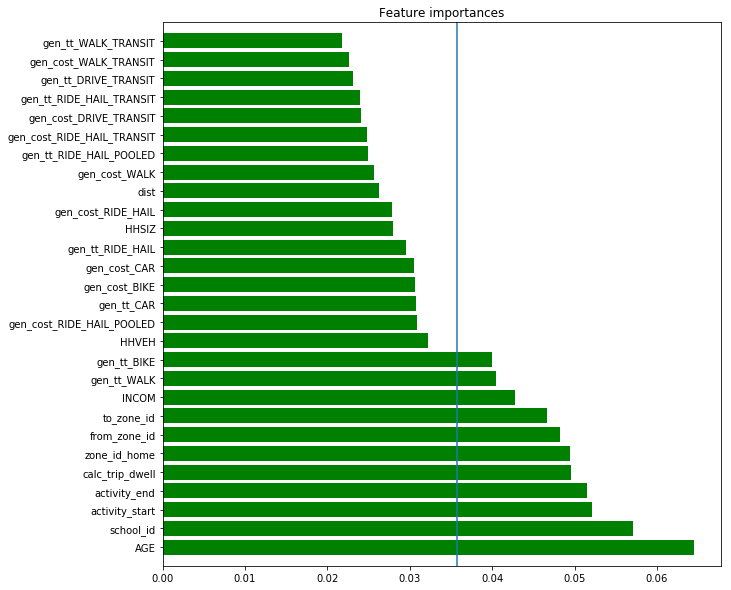

In [251]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.title("Feature importances")
plt.barh(range(X_selected.shape[1]), importances[indices],
       color="g", align="center")
plt.axvline(importances.mean())
plt.yticks(range(X_selected.shape[1]), X_selected.columns[indices])
plt.ylim([-1, X_selected.shape[1]])
plt.show()

In [252]:
feats = pd.DataFrame(data=importances[indices], index=X.columns[indices])
feats = feats.rename({0: "relative importance"}, axis=1)
feats.head()

,relative importance
AGE,0.064503
RACE1,0.057151
zone_id_home,0.052110
school_id,0.051485
activity_start,0.049563


#### Assess random forest model performance 

In [255]:
fitted.score(X_test, y_test)

0.6640159045725647

In [256]:
from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import SmallMultinomialLogitStep
from urbansim.utils import misc